# GPT API Fine Tuning for Sentiment Classification

Try gpt for your task before fine-tuning. If chatgpt is not enough, then fine-tune it. Do not forget that chat-gpt may be sufficient for most simple tasks.

To fine-tune the GPT-3.5 model, you need to convert each observation in your data to the following message template (Jsonline Format):

In [ ]:
# "{'messages': [{'role': 'system', 'content': 'Detect sentiment in the text.'},
#                {'role': 'user', 'content': 'It is a very nice pair of pants. I recommend it to everyone.'},
#                {'role': 'assistant', 'content': 'possitive'}]}"

# system: the instructions you give to the model.
# user: the feature/independent variable/text of each observation in your data (X)
# assistant: the dependent variable/target/label of each observation in your data (y).

In [1]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("/content/drive/MyDrive/clothing_reviews.csv")
df.head()

# We will fine-tune a data set with 1059 observations.

,text,label
0,This sweater is heavier and has more of a swin...,positive
1,When i read all these positive reviews i did n...,negative
2,The colors in this cardigan are not what they ...,positive
3,Perfect! very pretty and flattering without be...,positive
4,Such a festive sweater and i've received many ...,positive


In [13]:
len(df)

1059

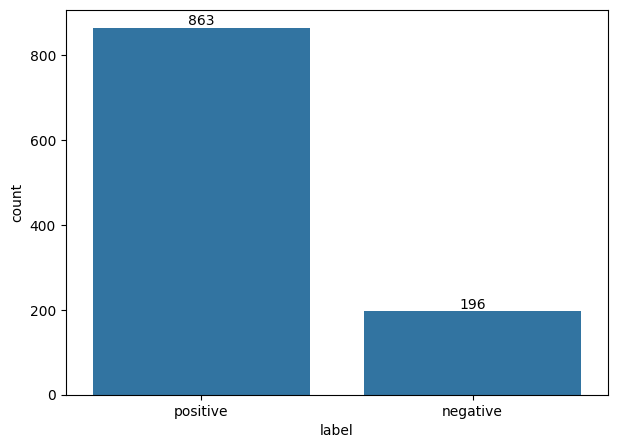

In [14]:
plt.fig = plt.figure(figsize = (7,5))
ax = sns.countplot(x="label",
                   data=df)
ax.bar_label(ax.containers[0]);

In [15]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=101)

In [17]:
print(len(X_train))
print(len(X_test))

953
106


In [18]:
X_train

814    I don't usually wear this much color, but i'm ...
599    I have been wanting this sweater and decided t...
462    I love the color and cut of the pants. they ar...
466    Runs almost two sizes small. i plan to wear as...
620    I noticed this outfit earlier this year and re...
                             ...                        
297    These jeans are very comfortable. the distress...
963    Wow, i got this top in blue and i'm in love. l...
74     Tts and comfortable. this t shirt brings flair...
313    This dress is amazing! it's perfect for a casu...
728    I have been wanting this coat ever since i tri...
Name: text, Length: 953, dtype: object

In [ ]:
import json
import pandas as pd

def convert_df_to_dict(X, y):
  """Converts X and y to dictionary format.

  Args:
    X: text
    y: label

  Returns:
    A dataframe(as X and y) in dictionary format.
  """

  dictionary = []
  for i, j in zip(X, y):
    dictionary.append({
        "messages": [
            {
                "role": "system",
                "content": "Detect sentiment in the text." # system content will be the same for all observations.
            },
            {
                "role": "user",
                "content": i
            },
            {
                "role": "assistant",
                "content": j
            }
        ]
    })

  return dictionary

# To convert observations to JSONLine format, we first need to convert them to dictionary format.

In [ ]:
train = convert_df_to_dict(X_train, y_train)
test = convert_df_to_dict(X_test, y_test)

# We convert train and test data into dictionary format separately.

In [ ]:
train[:2]

[{'messages': [{'role': 'system', 'content': 'Detect sentiment in the text.'},
   {'role': 'user',
    'content': "I don't usually wear this much color, but i'm so glad i purchased this top. it is really cute on and professional enough for work, but with a tank underneath and the buttons undone, its casual too. i have received several compliments both times i have worn the shirt. sleeves are a bit long."},
   {'role': 'assistant', 'content': 'positive'}]},
 {'messages': [{'role': 'system', 'content': 'Detect sentiment in the text.'},
   {'role': 'user',
    'content': 'I have been wanting this sweater and decided to order. when i received it, there was no tag on the product. it was not in a typical clear bag from retailer and it wasn\'t packaged nicely. it came from reno, nv. most products i order do not get shipped from there. it is short, and i\'m 5\'1". most clothes that are short fit me with no problem. this sweater might hit me at the waist, or maybe shorter. i think the color is 

In [ ]:
type(train[0]) # the type of observations is dict

dict

In [ ]:
import json

with open("train.jsonl", "w") as f:
    for item in train:
        f.write(json.dumps(item) + "\n") # Python uses the json.dumps() function to convert a dictionary to JSON format.
                                         # This function converts the dictionary into a JSON string.

# The train and test data that we will feed to the model for fine tuning should be in JSON line format. For this, all observations in dictionary format
# We convert to JSON line format.

# JSON format is the conversion of dictionary format to string.

# dict format: {'name': 'johnson', 'age':44}
# json format: “{‘name’: ‘johnson’, ‘age’:‘44’}”

In [ ]:
with open("test.jsonl", "w") as f:
    for item in test:
        f.write(json.dumps(item) + "\n")

# We apply the same JSON line transformation to the test data as we did to the train data.

In [ ]:
import json
import codecs

with codecs.open('train.jsonl', 'r', encoding='utf-8') as f:
  a = 0
  for line in f:
    print(type(line))
    print(line)
    a+=1

    if a==2:
      break

# We can see that all observations converted to JSON line format are in string type.

<class 'str'>
{"messages": [{"role": "system", "content": "Detect sentiment in the text."}, {"role": "user", "content": "I don't usually wear this much color, but i'm so glad i purchased this top. it is really cute on and professional enough for work, but with a tank underneath and the buttons undone, its casual too. i have received several compliments both times i have worn the shirt. sleeves are a bit long."}, {"role": "assistant", "content": "positive"}]}

<class 'str'>
{"messages": [{"role": "system", "content": "Detect sentiment in the text."}, {"role": "user", "content": "I have been wanting this sweater and decided to order. when i received it, there was no tag on the product. it was not in a typical clear bag from retailer and it wasn't packaged nicely. it came from reno, nv. most products i order do not get shipped from there. it is short, and i'm 5'1\". most clothes that are short fit me with no problem. this sweater might hit me at the waist, or maybe shorter. i think the co

## Data preparation and analysis for chat model fine-tuning


**Data loading**, **Format validation**, **Token Counting Utilities**, **Data Warnings and Token Counts**, ve **Cost Estimation** bölümleri için aşağıdaki kod blokları OpenAI tarafından hazırlanmıştır. Ve ince ayardan önce kullanılması tavsiye edilir.

Bu kod blokları, bir chatgpt modeline ince ayar yapmak için kullanılan datayı önceden işlemek ve analiz etmek için bir araç görevi görür. Biçim hatalarını kontrol eder, temel istatistikler sağlar ve ince ayar maliyetini belirlemek için gerekli olan token sayılarını tahmin eder.

In [ ]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

## Data loading

We first load the chat dataset from an example JSONL file.

In [ ]:
data_path = "/content/train.jsonl" # data_path değişkeni jsonl dosyasının yolunu belirtir.

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f: # with open() dosyayı açar ve json.loads() işlevini
                                                  # kullanarak her satırı bir dict nesnesi olarak yükler.

    dataset = [json.loads(line) for line in f] # tüm dict nesnelerini dataset listesine atıyoruz.

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(type(message))
    print(message)

Num examples: 953
First example:
<class 'dict'>
{'role': 'system', 'content': 'Detect sentiment in the text.'}
<class 'dict'>
{'role': 'user', 'content': "I don't usually wear this much color, but i'm so glad i purchased this top. it is really cute on and professional enough for work, but with a tank underneath and the buttons undone, its casual too. i have received several compliments both times i have worn the shirt. sleeves are a bit long."}
<class 'dict'>
{'role': 'assistant', 'content': 'positive'}


## Format validation

We can perform various error checks to verify that each observation in the dataset conforms to the format expected by the fine-tuning API. Errors are categorized according to their nature for easier debugging.

1.**Data Type Check: Checks whether each entry in the dataset is a dictionary (dict). Error type: data_type.

2.**Presence of Message List: Checks if there is a message list for each entry. Error type: missing_messages_list.

3.**Message Keys Check: Checks for the presence of “role” and “content” keys in messages. Error type: message_missing_key.

4.**Unrecognized Keys in Messages: Checks if a message has keys other than “role”, “content” and name(system, user, assistant). Error type: message_unrecognized_key.

5.**Role Validation: Confirms whether the “roles” are “system”, “user”, or “assistant”. Error type: unrecognized_role.

6.**Content Validation (content validation)**: confirms that the content is a string expression. Error type: missing_content.

7.**Assistant Message Presence: **: checks if the message contains content belonging to the assistant. Error type: example_missing_assistant_message.

The following code performs these checks and prints the number of any errors found. This is useful for debugging and checking if the dataset is ready for the next steps.

In [ ]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        if not content or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

# This function checks if the data is ready for fine tuning. It returns an error for missing or invalid data.
# returns the message “No error found” if there is no problem with the data.

No errors found


## Token Counting Utilities

Lets define a few helpful utilities to be used in the rest of the notebook.

In [ ]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.05)}, {np.quantile(values, 0.95)}")

## Data Warnings and Token Counts

With the following analyses, we can identify potential problems in the data, missing messages and provide statistical information about message and token counts.

1.**Missing System/User Messages**: Counts observations that are missing “system” or “user” messages. These messages are critical for identifying the assistant's behavior and initiating the conversation.

2.**Number of Messages Per Example**: Summarizes the distribution of the number of messages (system, user, assistant) in each observation and provides information about the dialog complexity. It checks if each message has 3 separate parts: system, user, assistant. If so, the min, max, mean, median, 5% and 95% of the number of parts in each message will always be 3. Otherwise, these values will be different from 3.

3.**Total Tokens Per Example**: Calculates and summarizes the distribution of the total number of tokens in each observation. It is important to understand the fine-tuning costs. This provides information about the total number of tokens and their distribution (mean, median, minimum, maximum, etc.) in each message, including system, user and assistant parts.

4.**Tokens in Assistant's Messages**: calculates the number of tokens in assistant's messages in each observation and summarizes this distribution (mean, median, minimum, maximum, etc.). Provides information about the assistant.

5.**Token Limit Warnings**:  Checks if any observation exceeds the maximum token limit (4096 tokens), because such observations will be clipped during fine-tuning, which will result in data loss.

In [ ]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 29, 166
mean / median: 94.63588667366211, 93.0
p5 / p95: 43.0, 145.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


NOTE: For test data, the Data loading, Format validation, Token Counting Utilities, Data Alerts and Token Counts sections also need to be done. We have done this only for training data to keep the notebook short.
But the cost estimation section is only done for training data.

## Cost Estimation

##### In this section, we estimate the total number of tokens that will be used for fine-tuning, which allows us to approximate the cost. <br> It is worth noting that as the number of tokens increases, the duration of the fine-tuning process will also increase.

In [ ]:
100//30

3

In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:  # if the product of the number of observations in the train data and TARGET_EPOCHS(3) is less than MIN_TARGET_EXAMPLES(100),
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples) # the smaller of MAX_DEFAULT_EPOCHS(25) or 100//(number of observations in train data) as epoch
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES: # if the number of observations in the train data times TARGET_EPOCHS(3) is greater than MAX_TARGET_EXAMPLES(2500),
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples) # epoch as MIN_DEFAULT_EPOCHS(1) or MIN_TARGET_EXAMPLES(25000)//(number of observations in train data) whichever is greater

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens) # total number of tokens for all comments, with a maximum number of tokens per comment not exceeding 4096
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens") # total number of tokens trained

current_price=8 # Price per one million tokens, please check the openai webpage for the current price.
print(f"Estimate total costs ~{(n_epochs * n_billing_tokens_in_dataset)/1000000 * current_price}")

# At least 10 observations must be given to the model for fine tuning. Otherwise the model will return an error. 
# However, for fine tuning, the model should be given a minimum of 100 and a maximum of 25000 observation is recommended.

# GPT 3.5-Turbo model works with 3 epochs by default for fine tuning. However, this code can be adjusted from a minimum of 1 to a maximum of 25, depending on the number of observations in your data.
# Suggests how many epochs of training you need to do.

# Returns the number of tokens to process over the entire training and the cost of fine-tuning based on this number of tokens.

# NOTE: This section will only apply to the training data.

Dataset has ~90188 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~270564 tokens
Estimate total costs ~2.164512


In [5]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY']=userdata.get('openai_key')

In [6]:
from openai import OpenAI

client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY']
)

In [ ]:
training_response = client.files.create(file=open("/content/train.jsonl", "rb"),
                                        purpose="fine-tune") # We prepare Train data for fine tuning.

training_file_id = training_response.id # We pull the ID created for the ready train data.

validation_response = client.files.create(file=open("/content/test.jsonl", "rb"),
                                          purpose="fine-tune") # We prepare the test data for fine tuning.

validation_file_id = validation_response.id # We retrieve the ID created for the ready test data.

print("Training file id:", training_file_id)
print("Validation file id:", validation_file_id)

Training file id: file-sXjDiGxp7D7XreO01jg4nXqr
Validation file id: file-E2ZWEdC8g2iX1pAOIAIS7SSh


In [ ]:
suffix_name = "sentiment analys 3"

response = client.fine_tuning.jobs.create(
    training_file=training_file_id, # The ID of the train data is given to the fine-tuning model. The ID of the train data must be provided
    validation_file=validation_file_id, #The ID of the validation dats is given to the fine-tuning model. Providing this ID is optional
    model="gpt-3.5-turbo", # For now the only model available is the GPT-3.5-turbo. We expect GPT-4 to be available in the near future.
    suffix=suffix_name, # We can add a suffix of our choice to the name of the fine-tuned model, but we cannot specify the exact name of the model.
    hyperparameters={"n_epochs":3}, # We are only allowed to set Epoch, batchsize and learning_rate_multiplier.
                                    # Since the recommended number of epochs is 3, we set the epoch to 3.
)

job_id = response.id # The ID of fine-tune model.

print(response)

FineTuningJob(id='ftjob-wHqUPL5DJQ1zQmfoWz2VgRkM', created_at=1713607674, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-b88r78OSLP9wnPnDMsswFKhJ', result_files=[], seed=1700530180, status='validating_files', trained_tokens=None, training_file='file-sXjDiGxp7D7XreO01jg4nXqr', validation_file='file-E2ZWEdC8g2iX1pAOIAIS7SSh', integrations=[], user_provided_suffix='sentiment analys 3')


In [8]:
job_id

'ftjob-wHqUPL5DJQ1zQmfoWz2VgRkM'

In [ ]:
#client.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-wHqUPL5DJQ1zQmfoWz2VgRkM', created_at=1713607674, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-b88r78OSLP9wnPnDMsswFKhJ', result_files=[], seed=1700530180, status='running', trained_tokens=None, training_file='file-sXjDiGxp7D7XreO01jg4nXqr', validation_file='file-E2ZWEdC8g2iX1pAOIAIS7SSh', integrations=[], user_provided_suffix='sentiment analys 3')

In [ ]:
client.fine_tuning.jobs.retrieve(job_id) # We get general information about fine tuning.

FineTuningJob(id='ftjob-wHqUPL5DJQ1zQmfoWz2VgRkM', created_at=1713607674, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371mLq', finished_at=1713612238, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-b88r78OSLP9wnPnDMsswFKhJ', result_files=['file-QdFR8GQ5baDhHlBzO237GqEG'], seed=1700530180, status='succeeded', trained_tokens=264846, training_file='file-sXjDiGxp7D7XreO01jg4nXqr', validation_file='file-E2ZWEdC8g2iX1pAOIAIS7SSh', integrations=[], user_provided_suffix='sentiment analys 3')

In [ ]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=30) # Displays the events of the fine-tuning process in the last 30 steps.

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-14LsUN2gSoopBDBXAfIDFVYU', created_at=1713612243, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-n18svbZw0LE4rRFWYocfM5Pl', created_at=1713612240, level='info', message='New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371mLq', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-2Tg8aV3RCYI0xs4GbvAnfaHU', created_at=1713612240, level='info', message='Checkpoint created at step 1906 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371HcG:ckpt-step-1906', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-qbXPcJ2RWVm7Fx3a56KAObKl', created_at=1713612240, level='info', message='Checkpoint created at step 953 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371Reu:ckpt-st

In [ ]:
response= client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id)

events=response.data

In [ ]:
events.reverse()# The first steps of the fine-tuning process will be at the beginning, using the reverse() function
                # We reverse the order of the fine-tuning steps.

In [ ]:
events

[FineTuningJobEvent(id='ftevent-QXZSQdida6anB9wmGeajpM3W', created_at=1713612207, level='info', message='Step 2844/2859: training loss=0.00', object='fine_tuning.job.event', data={'step': 2844, 'train_loss': 6.35782896551973e-07, 'total_steps': 2859, 'train_mean_token_accuracy': 0.6666666865348816}, type='metrics'),
 FineTuningJobEvent(id='ftevent-el77WxvHyXTcKkpZxkTsMqba', created_at=1713612209, level='info', message='Step 2845/2859: training loss=6.56', object='fine_tuning.job.event', data={'step': 2845, 'train_loss': 6.5570292472839355, 'total_steps': 2859, 'train_mean_token_accuracy': 0.6666666865348816}, type='metrics'),
 FineTuningJobEvent(id='ftevent-X5Sta6TkzGmqv4wGv5nxjTo8', created_at=1713612212, level='info', message='Step 2846/2859: training loss=0.00', object='fine_tuning.job.event', data={'step': 2846, 'train_loss': 6.35782896551973e-07, 'total_steps': 2859, 'train_mean_token_accuracy': 0.6666666865348816}, type='metrics'),
 FineTuningJobEvent(id='ftevent-4FmJXfhfszZlvU1L

In [ ]:
for event in events:
    print(event.message) #

Step 2844/2859: training loss=0.00
Step 2845/2859: training loss=6.56
Step 2846/2859: training loss=0.00
Step 2847/2859: training loss=0.00
Step 2848/2859: training loss=0.00
Step 2849/2859: training loss=0.00
Step 2850/2859: training loss=0.00
Step 2851/2859: training loss=0.00
Step 2852/2859: training loss=0.00
Step 2853/2859: training loss=6.13
Step 2854/2859: training loss=0.00
Step 2855/2859: training loss=0.00
Step 2856/2859: training loss=0.00
Step 2857/2859: training loss=0.00
Step 2858/2859: training loss=0.00
Step 2859/2859: training loss=1.04, full validation loss=0.14
Checkpoint created at step 953 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371Reu:ckpt-step-953
Checkpoint created at step 1906 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371HcG:ckpt-step-1906
New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371mLq
The job has successfully completed


In [ ]:
#client.fine_tuning.jobs.cancel(job_id)

# You can cancel the fine-tuning process you have started with this code. However, the fine-tuning process will start in 1-2 minutes,
# so you need to cancel it before that. If you don't, you won't be able to cancel it.

## Prediction

In [9]:
client.fine_tuning.jobs.retrieve(job_id) # First we get general information about fine-tuning. from here we will draw the fine-tune model name

FineTuningJob(id='ftjob-wHqUPL5DJQ1zQmfoWz2VgRkM', created_at=1713607674, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371mLq', finished_at=1713612238, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-b88r78OSLP9wnPnDMsswFKhJ', result_files=['file-QdFR8GQ5baDhHlBzO237GqEG'], seed=1700530180, status='succeeded', trained_tokens=264846, training_file='file-sXjDiGxp7D7XreO01jg4nXqr', validation_file='file-E2ZWEdC8g2iX1pAOIAIS7SSh', integrations=[], user_provided_suffix='sentiment analys 3')

In [10]:
model_name= client.fine_tuning.jobs.retrieve(job_id).fine_tuned_model # we pull the model name.
model_name

'ft:gpt-3.5-turbo-0125:personal:sentiment-analys-3:9G371mLq'

In [11]:
system="Detect sentiment in a text." # The system context for prediction is the same as the system context for fine tuning.

In [19]:
# Let's select a few observations from the test data and make predictions.
display(X_test.loc[246])
display(y_test.loc[246])

'I purchased this item in the gray heather color and loved it so much i wanted to buy every other color. the fabric was cottony and felt very soft and cushy against my skin, and the gray color was from the combination of black and white fibers. i ordered the light gray and the red online and could not wait for them to arrive. but the other colors were not even in the same material, but a very shiny and synthetic feeling fabric, with just a single color weave that did not have the same feel or tex'

'negative'

In [20]:
completion = client.chat.completions.create(
  model=model_name,
  messages=[
    {"role": "system", "content": system},
    {"role": "user", "content": X_test.loc[246]}
  ]
)

print(completion.choices[0].message.content)

negative


In [ ]:
display(X_test.loc[883])
display(y_test.loc[883])

'I love this dress! the fabric and overall design are beautiful. however, the dress fit runs small, at least for me. i ordered a size 10 based on the reviews. i have another byron lars dress in a size 8 that fits well. i kept the dress because it is so pretty.'

'positive'

In [ ]:
completion = client.chat.completions.create(
  model=model_name,
  messages=[
    {"role": "system", "content": system},
    {"role": "user", "content": X_test.loc[883]}
  ]
)

print(completion.choices[0].message.content)

positive


END OF THE PROJECT